# Foreground Extraction, Background Subtraction

<pre>
1. Consider a medical image from your medical image dataset selected. Implement the following:
	i.    Foreground Extraction using Grabcut Algorithm.
	ii.   Foreground Extraction using contour detection.
	iii.  Compare the result and say which approach foreground extraction was best suited for your input image.
2.  Consider a medical image from your medical image dataset selected.
Implement Background subtraction using BackgroundSubtractorMOG, BackgroundSubtractorMOG2 and BackgroundSubtractorGMG.
Compare the result and say which approach foreground extraction was best suited for your input image.
</pre>

# Kaggle Dataset

## Drive Connection

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


## Get key

In [ ]:
!mkdir /root/.kaggle/
!cp /drive/MyDrive/kaggle.json /root/.kaggle/

## Download dataset

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 3.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=be0e008b1b5aef9261656faf5079a6ee62dabc611b24a81696279f1ec7ec41ef
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.51G/9.51G [02:07<00:00, 78.1MB/s]
100% 9.51G/9.51G [02:07<00:00, 80.3MB/s]


In [ ]:
!unzip -qq aptos2019-blindness-detection.zip

# Get image to work on from dataset

In [ ]:
# get file name
import os

IMAGE_DIR = "train_images"
IMAGE_NAME = os.listdir(IMAGE_DIR)[2]
print(IMAGE_NAME)

2cf18033da31.png


# Get image from web

In [ ]:
!wget https://media.wired.com/photos/5c523ece95d28a2cb5b76db1/1:1/w_494,h_494,c_limit/Backchannel-Lena-Soderberg-FA.jpg -O image_reserve.jpg
IMAGE_DIR_2 = ""
IMAGE_NAME_2 = "image_reserve.jpg"

--2022-03-07 17:51:38--  https://media.wired.com/photos/5c523ece95d28a2cb5b76db1/1:1/w_494,h_494,c_limit/Backchannel-Lena-Soderberg-FA.jpg
Resolving media.wired.com (media.wired.com)... 151.101.0.239, 151.101.64.239, 151.101.128.239, ...
Connecting to media.wired.com (media.wired.com)|151.101.0.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54209 (53K) [image/jpeg]
Saving to: ‘image_reserve.jpg’

image_reserve.jpg   100%[===================>]  52.94K  --.-KB/s    in 0.003s  

2022-03-07 17:51:39 (15.9 MB/s) - ‘image_reserve.jpg’ saved [54209/54209]



# Loading and resizing image

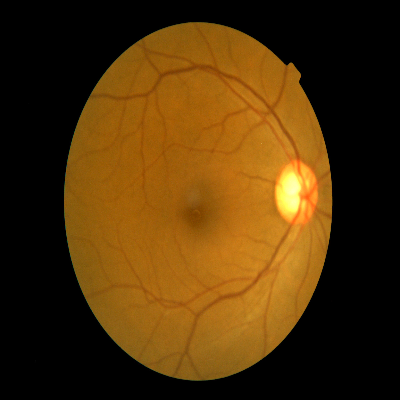

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

IMG_ORIGINAL = cv2.imread(os.path.join(IMAGE_DIR, IMAGE_NAME))

MAX_PIXEL = 255

# resize for better visibility
IMAGE_SIZE = (400, 400)
IMG = cv2.resize(IMG_ORIGINAL, IMAGE_SIZE)
cv2_imshow(IMG)

# Grayscale image

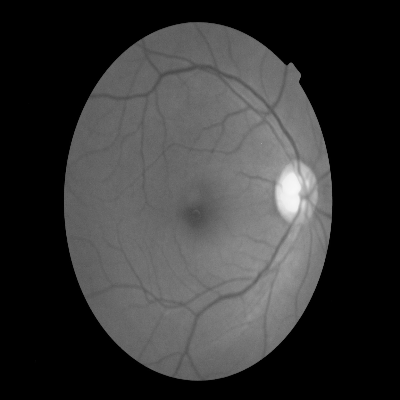

In [ ]:
IMG_GRAY = cv2.cvtColor(IMG, cv2.COLOR_BGR2GRAY)
cv2_imshow(IMG_GRAY)

# Loading the other image (from web)

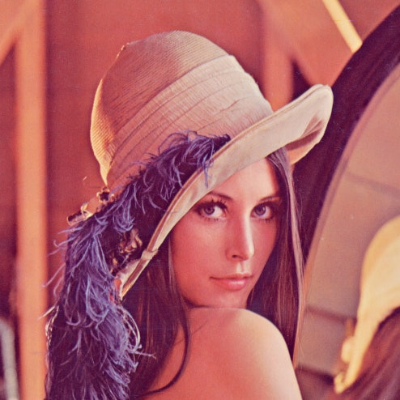

In [ ]:
IMG_ORIGINAL2 = cv2.imread(os.path.join(IMAGE_DIR_2, IMAGE_NAME_2))
IMG2 = cv2.resize(IMG_ORIGINAL2, IMAGE_SIZE)
cv2_imshow(IMG2)

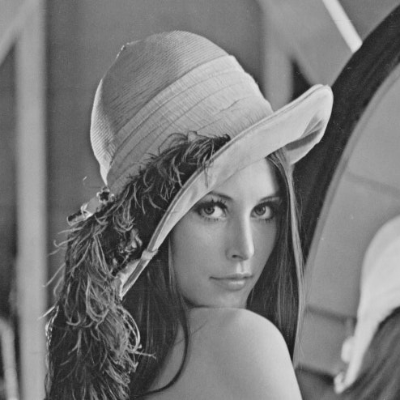

In [ ]:
IMG_GRAY2 = cv2.cvtColor(IMG2, cv2.COLOR_BGR2GRAY)
cv2_imshow(IMG_GRAY2)

# Side by side printer

In [ ]:
def h_printer(*images):
  return cv2.hconcat([img.astype('int32') for img in images])

# Imports

In [ ]:
import numpy as np

# Figuring out ROI

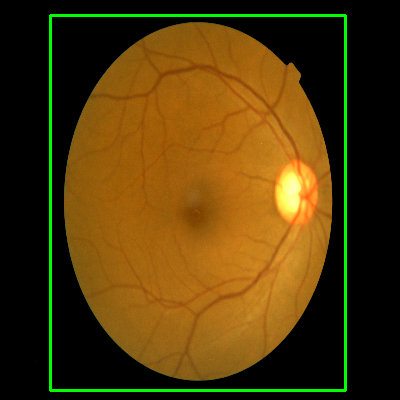

In [ ]:
START_POINT = (50, 15)
END_POINT = (345, 390)
cv2_imshow(cv2.rectangle(IMG.copy(), START_POINT, END_POINT, (0, 255, 0), 2))

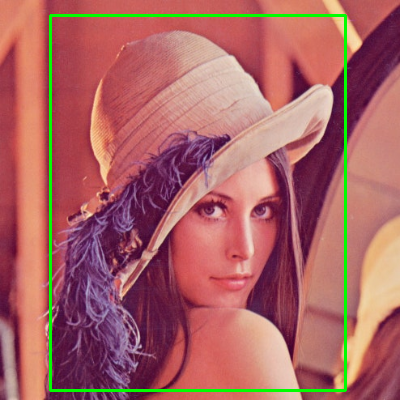

In [ ]:
START_POINT2 = (40, 15)
END_POINT2 = (340, 390)
cv2_imshow(cv2.rectangle(IMG2.copy(), START_POINT, END_POINT, (0, 255, 0), 2))

# Grab Cut Algorithm

In [ ]:
def grab_cut_show(image, START_POINT, END_POINT) :
  mask = np.zeros(image.shape[:2], np.uint8)
  backgroundModel = np.zeros((1, 65), np.float64)
  foregroundModel = np.zeros((1, 65), np.float64)
  rectangle = (*START_POINT, *END_POINT)
  cv2.grabCut(image, mask, rectangle, backgroundModel, foregroundModel,3, cv2.GC_INIT_WITH_RECT)
  mask2 = np.where((mask == 2)|(mask == 0), 0, 1).astype('uint8')
  image = image * mask2[:, :, np.newaxis]
  cv2_imshow(image)

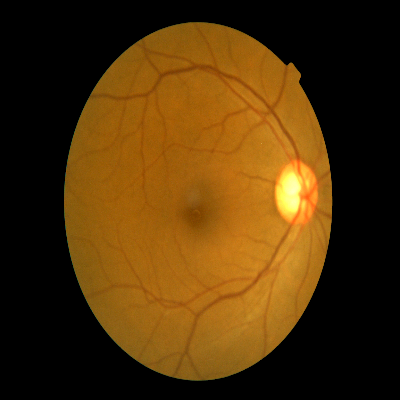

In [ ]:
grab_cut_show(IMG.copy(), START_POINT, END_POINT)

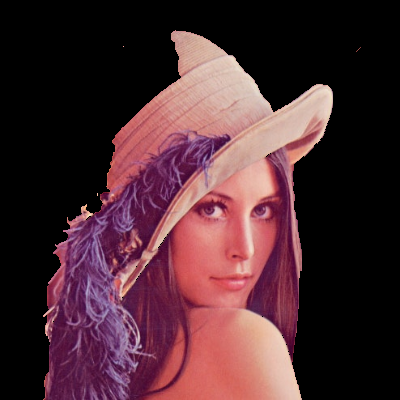

In [ ]:
grab_cut_show(IMG2.copy(), START_POINT2, END_POINT2)

# Contour Detection

## Find largest contour

In [ ]:
def find_largest_contour(image):
  image = image.astype(np.uint8)
  contours, hierarchy = cv2.findContours(
      image,
      cv2.RETR_TREE,
      cv2.CHAIN_APPROX_SIMPLE
  )
  largest_contour = max(contours, key=cv2.contourArea)
  return largest_contour

In [ ]:
def draw_largest_contour(image):
  contour = find_largest_contour(image)
  image_contour = np.copy(image)
  cv2.drawContours(image_contour, [contour], 0, (0, 255, 0), 2, cv2.LINE_AA, maxLevel=1)
  return image_contour

## Extract foreground and put on blue background

In [ ]:
def create_mask(gray) :
  mask = np.zeros_like(gray)
  mask = cv2.fillPoly(mask, [find_largest_contour(gray)], 255)
  res_mask = np.copy(mask)
  res_mask[mask == 0] = cv2.GC_BGD 
  res_mask[mask == 255] = cv2.GC_FGD
  return res_mask

def apply_green_background(image, image_gray):
  mask3d = create_mask(image_gray)
  foreground = cv2.multiply(mask3d, 1)
  background = np.full((foreground.shape[1], foreground.shape[0]), 1)
  background = background.astype(np.float64)
  background = cv2.multiply(1.0 - mask3d, background)
  
  b = []
  for i in range(image_gray.shape[0]):
    row = []
    for j in range(image_gray.shape[1]):
      row.append((255, 0, 0) if background[i][j]==1 else image[i][j])
    b.append(row)
  
  b = np.array(b)
  cv2_imshow(b)

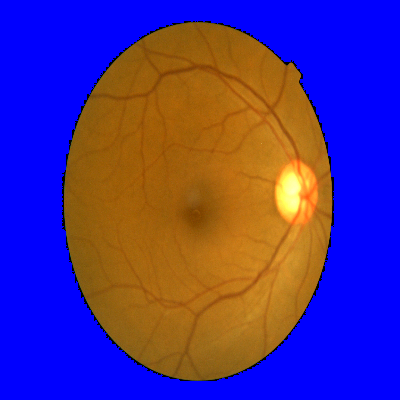

In [ ]:
apply_green_background(IMG, IMG_GRAY)

Conclusion 1 : Contour Detection seesm to fit better for my medical image dataset as it omits the step of ROI detection. It can detect images successfully on a wider range of images.

# Background Subtraction

## BackgroundSubtractorMOG

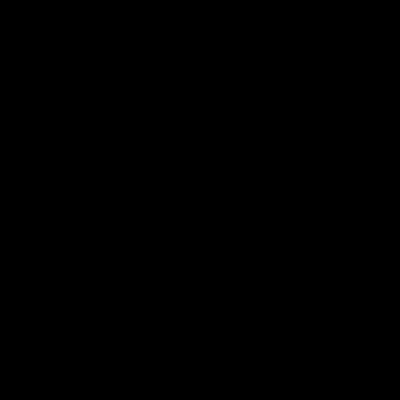

In [ ]:
fgbg = cv2.bgsegm.createBackgroundSubtractorMOG() 
fgmask = fgbg.apply(IMG.copy())
cv2_imshow(fgmask)

## BackgroundSubtractorMOG2

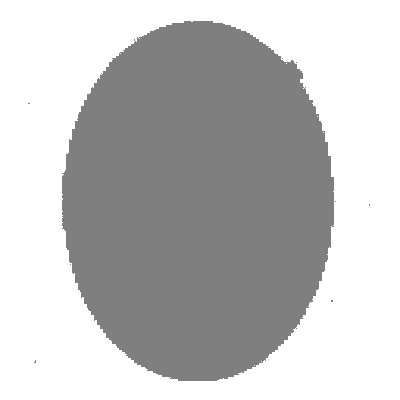

In [ ]:
fgbg = cv2.createBackgroundSubtractorMOG2()
fgmask = fgbg.apply(IMG.copy())
cv2_imshow(fgmask)

## BackgroundSubtractorGMG

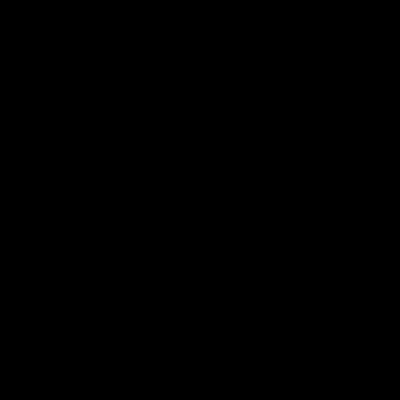

In [ ]:
fgbg = cv2.bgsegm.createBackgroundSubtractorGMG() 
fgmask = fgbg.apply(IMG.copy())
cv2_imshow(fgmask)

Conclusion 2 : As it is visible form results, on MOG2 algorithm works with my dataset